# Import the packages


(if running in colab): Uncomment the following lines to mount your Google drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import tensorflow as tf

2025-04-29 12:51:11.973639: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 12:51:11.982171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 12:51:11.996778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 12:51:11.996799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 12:51:12.005136: I tensorflow/core/platform/cpu_feature_gua

uncomment following lines to examine / set memory limit for GPU

In [3]:
#print(tf.config.list_physical_devices('GPU'))
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=2048)])

`pathname` is the path to the folder on the local or google drive that contains the fasta files you want to analyse; change as appropriate

In [4]:
pathname = '/home/rsidd/cnn_dna/benchmarks/atac_chip_datasets/ishitva/pos_neg_files/'
#!ls $pathname

Set the filenames you want to compare below, as well as the sequence length and (for cosmetic reasons) the labels for the classes. Right now binary only (two files, labels [0,1]). Pick seq length to be minimum length of sequences in files, ideally make files have all sequences be same length and set seq_length to that

In [5]:
facname="CTCF"

In [6]:
filelist_train = [facname+"_negative_train.fa.gz", facname+"_positive_train.fa.gz"]
#filelist_valid = ["3_negative_3000_valid.fa.gz", "3_positive_3000_valid.fa.gz"]
filelist_test = [facname+"_negative_test.fa.gz", facname+"_positive_test.fa.gz"]
filelist_train = [pathname+f for f in filelist_train]
#filelist_valid = [pathname+f for f in filelist_valid]
filelist_test = [pathname+f for f in filelist_test]

labels = [0,1]
labelnames = ["not bound", "bound"]
samples = "/".join(labelnames)
seq_length = 999

Now you can hopefully run the rest of the notebook and it should do the right thing

In [7]:

import warnings
warnings.filterwarnings("ignore")

In [8]:
import sys
import os
import glob
import numpy as np
import random

from sklearn.preprocessing import OrdinalEncoder
from numpy import asarray


from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,AveragePooling1D,BatchNormalization,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History,ReduceLROnPlateau, Callback,CSVLogger,EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, f1_score, precision_score, recall_score,precision_recall_curve,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score,precision_recall_curve
from sklearn.metrics.cluster import adjusted_rand_score,v_measure_score,fowlkes_mallows_score,mutual_info_score,rand_score


import matplotlib.pyplot as plt
import seaborn as sns
import gzip


In [9]:
def readfasta(filename):
    fastalist=[]
    if filename.endswith('.gz'):
      f = gzip.open(filename,'rt')
    else:
      f = open(filename,'rt')
    fl = f.read().splitlines()
    f.close()

    currhead=""
    currseq=""
    for l in fl:
        if l=="":
            continue
        if l[0]==">":
            if currhead:
                fastalist += [(currhead,currseq)]
            currhead = l
            currseq=""
            continue
        l = "".join([c for c in l if c != ""])
        if (l[0].upper()>='A' and l[0].upper()<='Z') or l[0]=='-':
            currseq += "".join(l.split())
    return fastalist+[(currhead,currseq)]


In [10]:
def one_hot_encode(sequence):
    DNA_encode = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], "N": [0, 0, 0, 0], "F": [0, 0, 0, 0]}
    for x in "acgtnf":
      DNA_encode[x] = DNA_encode[x.upper()]
    default_encoding = [0, 0, 0, 0]  # Default encoding for unrecognized characters
    return [DNA_encode.get(nucleotide, default_encoding) for nucleotide in sequence]



def encode_seq(seqlist,length):
    one_hot_sequences = [one_hot_encode(s[0:length]) for s in seqlist]
    one_hot_sequences_np = np.array(one_hot_sequences)
    reshaped_data_seq = one_hot_sequences_np.reshape((-1, seq_length, 4))
    return reshaped_data_seq


def get_encseqs_labels(filelist,length=1000):
  fseqs = [readfasta(f) for f in filelist]
  print(len(fseqs), len(fseqs[0]))
  seqlist = []
  labels = []
  label = 0
  for seqs in fseqs:
    for [h,s] in seqs:
      seqlist += [s]
      labels += [label]
    label += 1
  encseqs = encode_seq(seqlist,length)
  return encseqs, np.array(labels)

def get_encseqs(filename,length=1000):
  seqs = readfasta(filename)
  seqlist = []
  for [h,s] in seqs:
    seqlist += [s[0:length]]
  encseqs = encode_seq(seqlist,length)
  return encseqs

def model_split_data(encode_seq, encode_label, test_size=0.25, val_size=None, random_state=45):
    if test_size is None:
        # split data into train and valid sets, no test set
        X_train, X_val, y_train, y_val = train_test_split(encode_seq, encode_label, test_size=val_size, random_state=random_state)
        X_test, y_test = [],[]

        return X_train, X_val, X_test, y_train, y_val, y_test
    elif val_size is None:
        # Split data into train and temporary sets
        X_train, X_temp, y_train, y_temp = train_test_split(encode_seq, encode_label, test_size=test_size, random_state=random_state)

        # Split temporary set into validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
        #get_split_data_shape(X_train, X_val, X_test, y_train, y_val, y_test)

        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        # Calculate the size of validation set based on val_size parameter
        val_split = val_size / (1 - test_size)

        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(encode_seq, encode_label, test_size=test_size, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split, random_state=random_state)
        #get_split_data_shape(X_train, X_val, X_test, y_train, y_val, y_test)

        return X_train, X_val, X_test, y_train, y_val, y_test

def get_split_data_shape(X_train, X_val, X_test, y_train, y_val, y_test):
  print("X_train",X_train.shape)
  print("X_val",X_val.shape)
  print("X_test",X_test.shape)
  print("y_train",y_train.shape)
  print("y_val",y_val.shape)
  print("y_test",y_test.shape)


def loss_plot(loss,validation_loss,X_label ="Epochs",Y_label= 'Loss',Title="Training vs Validation Loss",legend_location="upper left",fig_size=(8, 6)):
  plt.figure(figsize=fig_size)
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, marker='o', linestyle='-', label='Training Loss')
  plt.plot(epochs, validation_loss, marker='o', linestyle='-', label='Validation Loss')
  plt.xlabel(X_label)
  plt.ylabel(Y_label)
  plt.title(Title)
  plt.legend(loc=legend_location, bbox_to_anchor=(1, 1))
  plt.grid(True)
  plt.show()

def Accuracy_plot(Accuracy,validation_accuracy,X_label ="Epochs",Y_label= 'Accuracy',Title="Training vs Validation Accuracy",legend_location="upper left",fig_size=(8, 6)):
  plt.figure(figsize=fig_size)
  epochs = range(1, len(Accuracy) + 1)
  plt.plot(epochs, Accuracy, marker='o', linestyle='-', label='Training Accuracy')
  plt.plot(epochs, validation_accuracy, marker='o', linestyle='-', label='Validation Accuracy')
  plt.xlabel(X_label)
  plt.ylabel(Y_label)
  plt.title(Title)
  plt.legend(loc=legend_location, bbox_to_anchor=(1, 1))
  plt.grid(True)
  plt.show()


def Binary_Confusion_Matrix(model,X_test,y_test,labelnames=labelnames,color=None):
   labels = list(range(len(labelnames)))
   y_predict = model.predict(X_test).round()
   cm = confusion_matrix(y_test,y_predict,labels = labels)
   display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelnames)
   display.plot(cmap=color)
   plt.show()


def AUC_ROC_Curve(model, X_test, y_test, labels_keys=None, labels_values=None, fig_size=(8, 6),Title='AUC-ROC Curve',xlabel='False Positive Rate',ylabel='True Positive Rate'):
    y_predict = model.predict(X_test)
    plt.figure(figsize=fig_size)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_predict)
    auc_score = auc(fpr_keras, tpr_keras)
    plt.plot(fpr_keras, tpr_keras, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.legend()
    plt.grid(True)
    plt.show()



# ploting the precision recall for each classes
def Class_Precision_Recall_Curve(model, X_test, y_test, labels_keys=None, labels_values=None,fig_size =(8,6),Title='Precision-Recall Curve',xlabel='Recall',ylabel='Precision'):
    y_predict = model.predict(X_test)
    labels_values = list(labels_values)
    labels_keys = list(labels_keys)

    plt.figure(figsize=fig_size)

    # Iterate over each class
    for i in range(len(labels_values)):
        precision, recall, _ = precision_recall_curve(y_test, y_predict)
        plt.plot(recall, precision, label=labels_keys[i])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.legend()
    plt.grid(True)

    plt.show()


# Ploting the precession with auc
def AUC_Precision_Recall_Curve(model, X_test, y_test, fig_size =(8,6),Title='AUC Precision-Recall Curve',xlabel='Recall',ylabel='Precision'):
    y_predict = model.predict(X_test)
    plt.figure(figsize=fig_size)
    precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.4f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(Title)
    plt.legend()
    plt.grid(True)
    plt.show()


def accuracy(y_true, y_pred):
    correct_predictions = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct_predictions += 1
    return correct_predictions / len(y_true)

def loss(y_true, y_pred):
    loss_count = 0
    for yt, yp in zip(y_true, y_pred):
        if yt != yp:
            loss_count += 1
    return loss_count / len(y_true)

def get_bias(labels):
  counts = np.bincount(labels)
  return np.log(counts[1]/counts[0])

def get_weights(labels):
  counts = np.bincount(labels)
  w0 = 1.0 / counts[0]
  w1 = 1.0 / counts[1]
  wt = w0+w1
  w0, w1 = w0/wt, w1/wt
  return {0:w0, 1:w1}


# Data

In [11]:
encode_Seq, encoded_labels  = get_encseqs_labels(filelist_train, seq_length)
#X_train, y_train = get_encseqs_labels(filelist_train, seq_length)
#X_valid, y_valid = get_encseqs_labels(filelist_valid, seq_length)
#X_test, y_test = get_encseqs_labels(filelist_test, seq_length)


2 2100


In [12]:
X_train,X_valid,X_test,y_train,y_valid,y_test =\
 model_split_data(encode_Seq,encoded_labels, test_size=None, val_size=0.2)

In [13]:
X_test,y_test = get_encseqs_labels(filelist_test, seq_length)

2 900


In [14]:
get_split_data_shape(X_train, X_valid, X_test, y_train, y_valid, y_test)

X_train (3360, 999, 4)
X_val (840, 999, 4)
X_test (1800, 999, 4)
y_train (3360,)
y_val (840,)
y_test (1800,)


In [24]:
#setting the default parameter
input_shape = (seq_length,4)
epochs = 50
batch_size = 32
motif_length = 5 #12
kernel = motif_length


num_classes = 1
loss_func = "binary_crossentropy"
optimizer = "adam"
#metrics = ["accuracy"]
activation = "sigmoid"
initial_bias = keras.initializers.Constant(get_bias(encoded_labels))
class_weight = get_weights(encoded_labels)

#metrics = [
#      keras.metrics.Accuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
#   #   keras.metrics.AUC(name='auc'),
#   #   keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
#]

weighted_metrics = [
# "accuracy",
#  keras.metrics.BinaryAccuracy(name='binary_accuracy'),
#   #   keras.metrics.Accuracy(name='accuracy'),
#  keras.metrics.Precision(name='precision'),
#  keras.metrics.Recall(name='recall'),
#  keras.metrics.AUC(name='auc'),
   keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
   #keras.metrics.AUC(name='auc'),
   #keras.metrics.BinaryAccuracy(name='binary_accuracy'),
   "accuracy",
]
#weighted_metrics = ["accuracy"]
#weighted_metrics = [ keras.metrics.AUC(name='auc'),
#                    "accuracy"]

# loss_func = "sparse_categorical_crossentropy"
# optimizer = "adam"
# metrics = ["accuracy"]
# activation = "softmax"

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
call_back_list = [early_stopping]

In [25]:
#initial_bias=keras.initializers.Constant(0.0)

In [26]:
get_bias(y_test)
#initial_bias=keras.initializers.Constant(0.0)

0.0

In [27]:
class_weight #= {0:0.5,1:0.5}

{0: 0.5, 1: 0.5}

In [28]:
def CNN_model(kernel_filter=32,kernel_size = 4,input_shape=None,class_count = None,
              activation_func = None, output_bias=None):
  model = Sequential([
          # feature learning layer 1
          layers.Conv1D(kernel_filter,kernel_size,activation = "relu",padding = "same",input_shape =input_shape,name="first_conv"),
          layers.Conv1D(kernel_filter,kernel_size,activation = "relu",padding = "same",name="second_conv"),
          layers.MaxPooling1D(8,padding="same"),
          layers.Dropout(0.2),
          layers.Conv1D(kernel_filter,kernel_size,activation = "relu",padding = "same",name="third_conv"),
          layers.Conv1D(kernel_filter,kernel_size,activation = "relu",padding = "same",name="forth_conv"),
          layers.MaxPooling1D(8,padding="same"),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dropout(0.1),
          layers.Dense(class_count,activation=activation_func, bias_initializer=output_bias)
          ])
  # Model Compiling
  model.compile(loss=loss_func,optimizer=optimizer,weighted_metrics=weighted_metrics)
  return model

model = CNN_model(input_shape=input_shape, class_count=num_classes, kernel_size=motif_length,
                  activation_func = activation, output_bias = None)
model.build()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_conv (Conv1D)             │ (None, 999, 32)        │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_conv (Conv1D)            │ (None, 999, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ third_conv (Conv1D)             │ (None, 125, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forth_conv (Conv1D)             │ (None, 125, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

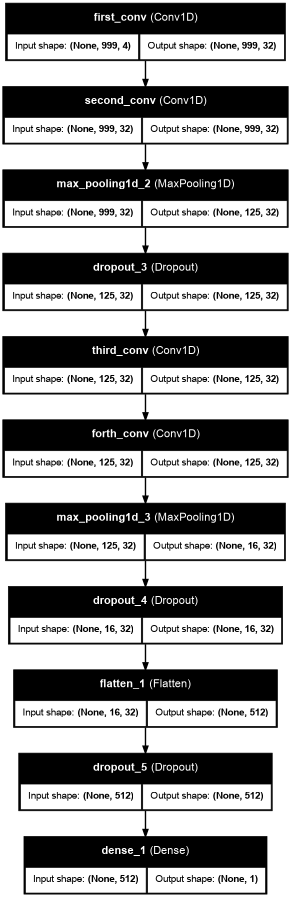

In [29]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=50)#, dpi=200, to_file='/home/rsidd/cnnmodel.png')

In [30]:
model_history = model.fit(X_train, y_train, epochs=epochs,
                          batch_size=batch_size, validation_data=(X_valid,y_valid),
                          class_weight = class_weight,
                          #class_weight={0:0.001,1:0.999},
                          callbacks=call_back_list)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5277 - loss: 0.3591 - prc: 0.5116 - val_accuracy: 0.5619 - val_loss: 0.6895 - val_prc: 0.5783
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5590 - loss: 0.3383 - prc: 0.5792 - val_accuracy: 0.5738 - val_loss: 0.6750 - val_prc: 0.6597
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6267 - loss: 0.3216 - prc: 0.6881 - val_accuracy: 0.6488 - val_loss: 0.6216 - val_prc: 0.7290
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6386 - loss: 0.3183 - prc: 0.7024 - val_accuracy: 0.6345 - val_loss: 0.6384 - val_prc: 0.7367
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6708 - loss: 0.3073 - prc: 0.7141 - val_accuracy: 0.6881 - val_loss: 0.5841 - val_prc: 0.7687
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7053 - loss: 0.2858 - prc: 0.7870 - val_accuracy: 0.7167 - val_loss: 0.5635 - val_prc: 0.8048
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━

In [31]:
model.evaluate(X_test,y_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8517 - loss: 0.3912 - prc: 0.4412


[0.38685017824172974, 0.9208196401596069, 0.8311111330986023]

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


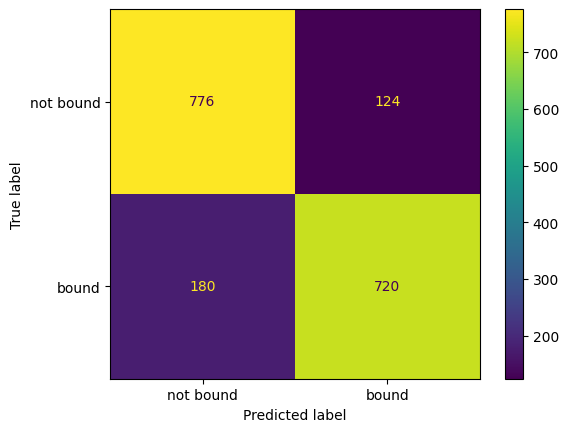

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


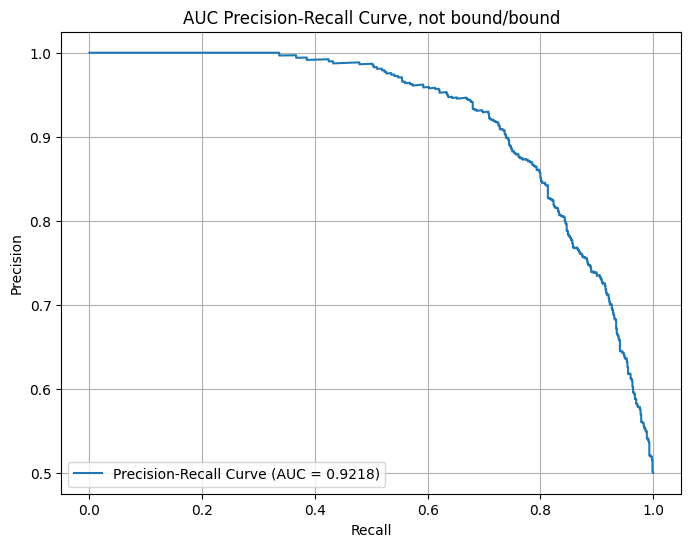

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


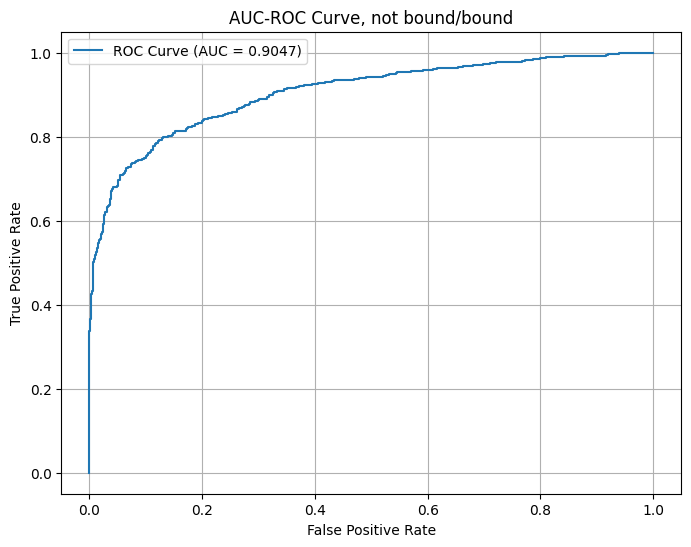

In [32]:
import matplotlib.pyplot as plt
Binary_Confusion_Matrix(model,X_test,y_test,labelnames=labelnames)

AUC_Precision_Recall_Curve(model, X_test, y_test, fig_size =(8,6),Title=f'AUC Precision-Recall Curve, '+samples,xlabel='Recall',ylabel='Precision')
AUC_ROC_Curve(model, X_test, y_test, labels_keys=None, labels_values=None, fig_size=(8, 6),Title=f'AUC-ROC Curve, '+labelnames[0]+"/"+labelnames[1],xlabel='False Positive Rate',ylabel='True Positive Rate')